In [180]:
import pandas as pd
import os
import catomatic
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

from protocols import utils

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Helvetica'  
plt.rcParams['font.size'] =7 
plt.rcParams['figure.figsize'] = (6.69, 5.02)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Methods notebook

This notebook generates, compares, and analyses the training and validation sets used in the Result notebook.

We have 3 key datasets, which themselves are different cryptic releases:
- CRyPTIC v1 - the original cryptic release. Also used to build the WHO catalogue, and is therefore the only like-for-like dataset we have.
- CRyPTIC v3.1.0 - CRyPTIC v1 + a bunch of samples processed since then as part of the cryptic project + nearly 9000 (at the moment less than this as many are nanopore sequences) samples collected and collated independently of the cryptic project and uploaded to the ena with genomes.

It logically follows that we build an initial catalogue on CRyPTICv1 which we can compare contents and performance to WHOv1 like for like. 

We can then independently validate this on CRypTICv3.1.0 - CRypTICv1 (along with WHOv1).

We can then build and release the most up-to-date catalogue trainED on crypticv3.1.0. We can also validate on CRyPTICv3.1.0 - CRypTICv1, but the problem is we can't indepdnently validate this, so performance will be over-estimated. We can also compare performance to WHOv2 on this validation set (but we dont know what sampels went into WHOv2, so not necessarily indepdendent).

In [211]:
v1_pheno = pd.read_pickle('data/cryptic-tables-v1/DST_MEASUREMENTS.pkl.gz').reset_index()
v1_geno = pd.read_pickle('data/cryptic-tables-v1/GENOMES.pkl.gz').reset_index()
crypticv1 = pd.merge(v1_pheno, v1_geno, on=['UNIQUEID'], how='inner')

v3_pheno = pd.read_pickle('data/cryptic-tables-v3.1.0/DST_MEASUREMENTS.pkl.gz').reset_index()
v3_geno = pd.read_parquet('data/cryptic-tables-v3.1.0/GENOMES.parquet').reset_index()
crypticv3 = pd.read_parquet('data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet').reset_index()
crypticv3 = crypticv3[crypticv3.in_final_tables]
crypticv3_actual = pd.merge(v3_geno, v3_pheno, on=['UNIQUEID'], how='inner')

v30_geno = pd.read_parquet('data/cryptic-tables-v3.0.0-alpha.1/GENOMES.parquet').reset_index()
crypticv30 = pd.read_parquet('data/cryptic-tables-v3.0.0-alpha.1/SAMPLES.parquet').reset_index()
crypticv30 = crypticv30[crypticv30.in_final_tables]


In [210]:
v30_geno

UNIQUEID          SPECIES  \
0           site.10.subj.YA00019967.lab.YA00019967.iso.1  M. tuberculosis   
1                 site.ENA.subj.SAMEA1019012.lab.1.iso.1  M. tuberculosis   
2                    site.04.subj.06941.lab.932089.iso.1  M. tuberculosis   
3                site.24.subj.PT-1110.lab.2019-594.iso.1  M. tuberculosis   
4      site.07.subj.85D59B8A-8A92-4DFC-BAB6-6762CB3D4...  M. tuberculosis   
...                                                  ...              ...   
41570                site.04.subj.03146.lab.824332.iso.1  M. tuberculosis   
41571  site.07.subj.B3B8F222-EA52-4E21-BAA2-0FFCA1409...  M. tuberculosis   
41572             site.ENA.subj.SAMN03648088.lab.1.iso.1  M. tuberculosis   
41573             site.ENA.subj.SAMN01908799.lab.1.iso.1  M. tuberculosis   
41574             site.ENA.subj.SAMN03649065.lab.1.iso.1  M. tuberculosis   

       N_LINEAGES   LINEAGE      SUBLINEAGE  MYCOBACTERIAL_READS  TB_READS  \
0               1  lineage1    lineage1.2.2              3923920   3844218   
1               1  lineage4     lineage4.10              5786288   5653086   
2               1  lineage2    lineage2.2.3              3839640   3769897   
3               1  lineage1    lineage1.1.2              1447432   1418317   
4               1  lineage4  lineage4.4.1.1              1558916   1532246   
...           ...       ...             ...                  ...       ...   
41570           1  lineage4     lineage4.10              5211830   5110516   
41571           1  lineage4    lineage4.3.2              2743484   2667034   
41572           1  lineage4  lineage4.6.2.2              4461874   4359205   
41573           1  lineage4  lineage4.3.4.1              3338558   3269109   
41574           1  lineage4  lineage4.3.4.1              1284998   1266998   

       TB_COVERAGE  TB_DEPTH     ANTIBIOGRAM PIPELINE_BUILD  
0          99.4005  126.3520  RRRRUUSSSSRSRS        88cb074  
1          98.2433   88.6138  SSSSSSSSSSUSSU        149a518  
2          99.5663  118.3380  RRRRRRSSRRRSRS        d5f9cd0  
3          99.4279   69.4543  SSSSSSSSSSSSSS        d5f9cd0  
4          99.3188   48.5172  SSSSSSSSSSSSSS        d5f9cd0  
...            ...       ...             ...            ...  
41570      99.7035  159.5980  RRSRSSSSSSRSSS        d5f9cd0  
41571      99.4982   58.5718  SRSSSSSSSSFSSS        d5f9cd0  
41572      99.5433   97.2486  RSSSSSSSSSRSUS        149a518  
41573      98.7768   59.8159  SSSSUUSUSSSSSS        149a518  
41574      98.7041   41.2460  SSSSSSSSSSSSSS        149a518  

[41575 rows x 11 columns]

In [244]:
set_v1 = set(crypticv1['UNIQUEID'])
set_geno_v30 = set(v30_geno['UNIQUEID'])

len(set_v1 - set_v3)


2495

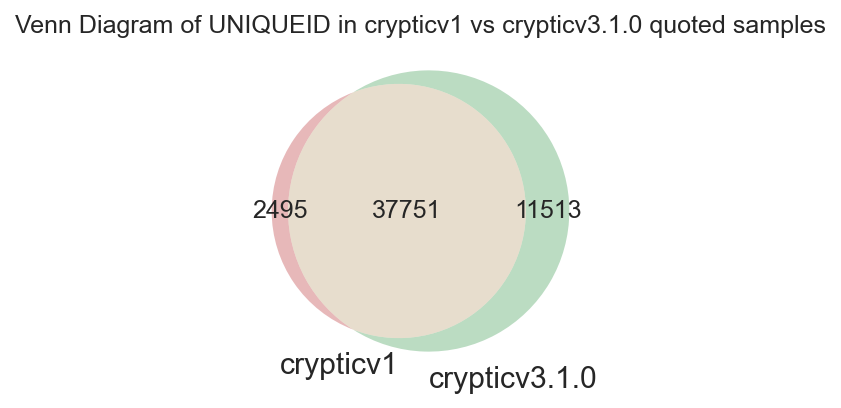

In [243]:
# Extract unique UNIQUEID from both datasets
set_v1 = set(crypticv1['UNIQUEID'])
set_v3 = set(crypticv3['UNIQUEID'])

# Calculate counts
shared_count = len(set_v1 & set_v3)  # Intersection
only_v1_count = len(set_v1 - set_v3)  # Unique to crypticv1
only_v3_count = len(set_v3 - set_v1)  # Unique to crypticv3

# Plot Venn diagram
plt.figure(figsize=(3, 3))
venn = venn2(subsets=(only_v1_count, only_v3_count, shared_count), 
             set_labels=('crypticv1', 'crypticv3.1.0'))

plt.title("Venn Diagram of UNIQUEID in crypticv1 vs crypticv3.1.0 quoted samples")
plt.show()


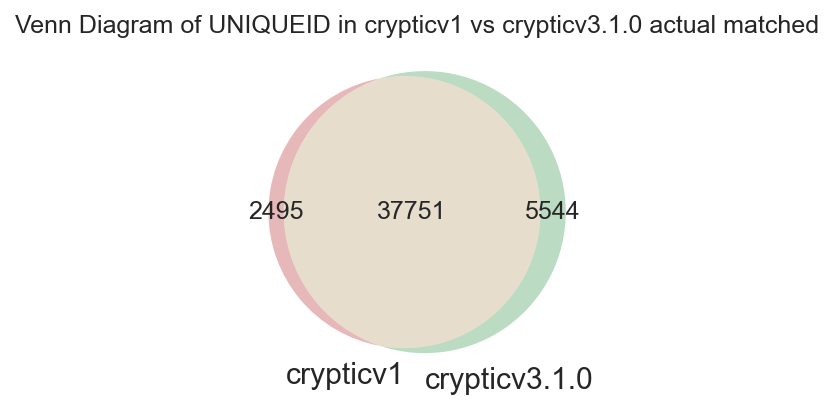

In [239]:
# Extract unique UNIQUEID from both datasets
set_v1 = set(crypticv1['UNIQUEID'])
set_v3 = set(crypticv3_actual['UNIQUEID'])

# Calculate counts
shared_count = len(set_v1 & set_v3)  # Intersection
only_v1_count = len(set_v1 - set_v3)  # Unique to crypticv1
only_v3_count = len(set_v3 - set_v1)  # Unique to crypticv3

# Plot Venn diagram
plt.figure(figsize=(3, 3))
venn = venn2(subsets=(only_v1_count, only_v3_count, shared_count), 
             set_labels=('crypticv1', 'crypticv3.1.0'))

plt.title("Venn Diagram of UNIQUEID in crypticv1 vs crypticv3.1.0 actual matched")
plt.show()


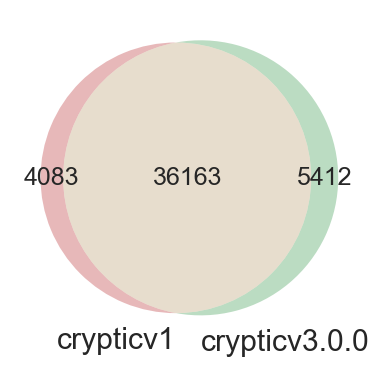

In [234]:
# Extract unique UNIQUEID from both datasets
set_v1 = set(crypticv1['UNIQUEID'])
set_v3 = set(crypticv30['UNIQUEID'])

# Calculate counts
shared_count = len(set_v1 & set_v3)  # Intersection
only_v1_count = len(set_v1 - set_v3)  # Unique to crypticv1
only_v3_count = len(set_v3 - set_v1)  # Unique to crypticv3

# Plot Venn diagram
plt.figure(figsize=(3, 3))
venn = venn2(subsets=(only_v1_count, only_v3_count, shared_count), 
             set_labels=('crypticv1', 'crypticv3.0.0'))

plt.show()

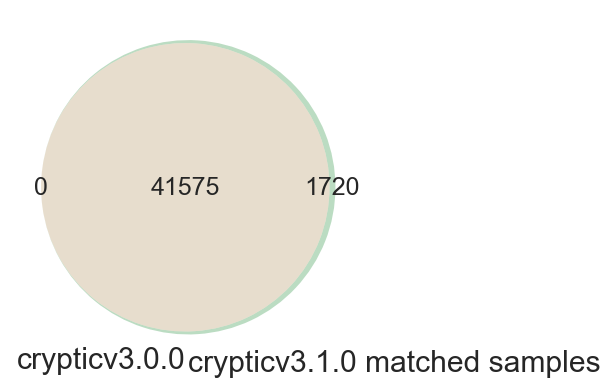

In [235]:
# Extract unique UNIQUEID from both datasets
set_v1 = set(crypticv30['UNIQUEID'])
set_v3 = set(crypticv3_actual['UNIQUEID'])


# Calculate counts
shared_count = len(set_v1 & set_v3)  # Intersection
only_v1_count = len(set_v1 - set_v3)  # Unique to crypticv1
only_v3_count = len(set_v3 - set_v1)  # Unique to crypticv3

# Plot Venn diagram
plt.figure(figsize=(3, 3))
venn = venn2(subsets=(only_v1_count, only_v3_count, shared_count), 
             set_labels=('crypticv3.0.0', 'crypticv3.1.0 matched samples'))

plt.show()

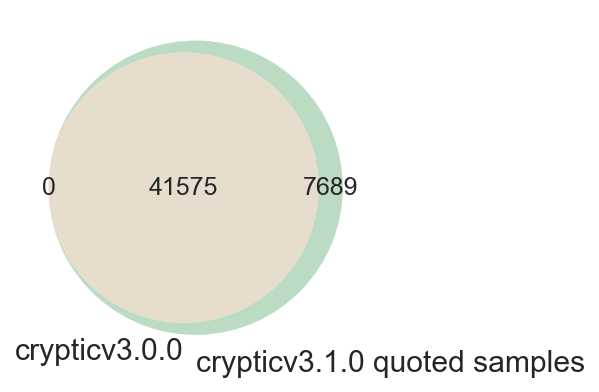

In [236]:
# Extract unique UNIQUEID from both datasets
set_v30 = set(crypticv30['UNIQUEID'])
set_v3 = set(crypticv3['UNIQUEID'])

# Calculate counts
shared_count = len(set_v30 & set_v3)  # Intersection
only_v30_count = len(set_v30 - set_v3)  # Unique to crypticv1
only_v3_count = len(set_v3 - set_v30)  # Unique to crypticv3

# Plot Venn diagram
plt.figure(figsize=(3, 3))
venn = venn2(subsets=(only_v30_count, only_v3_count, shared_count), 
             set_labels=('crypticv3.0.0', 'crypticv3.1.0 quoted samples'))

plt.show()

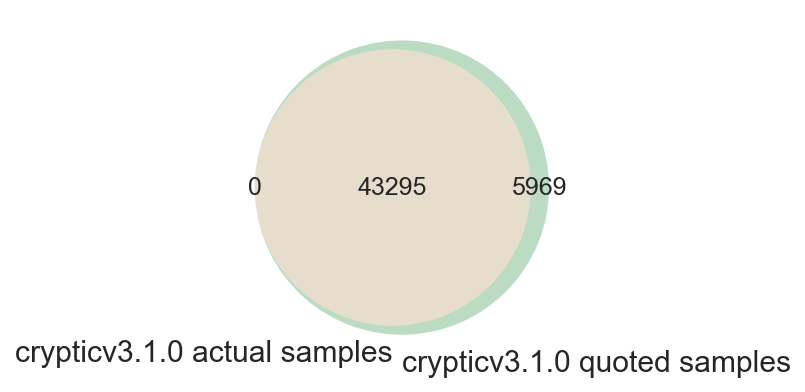

In [237]:
# Extract unique UNIQUEID from both datasets
set_v1 = set(crypticv3_actual['UNIQUEID'])
set_v3 = set(crypticv3['UNIQUEID'])

# Calculate counts
shared_count = len(set_v1 & set_v3)  # Intersection
only_v1_count = len(set_v1 - set_v3)  # Unique to crypticv1
only_v3_count = len(set_v3 - set_v1)  # Unique to crypticv3

# Plot Venn diagram
plt.figure(figsize=(3, 3))
venn = venn2(subsets=(only_v1_count, only_v3_count, shared_count), 
             set_labels=('crypticv3.1.0 actual samples', 'crypticv3.1.0 quoted samples'))

plt.show()

We gain 11593 samples but lose 2495 when going from crypticv1 to crypticv3.1.0. If quoted number of matched samples is correct (check by comp with mutations table - can do in a results loop somewhere), this would be a better option to use for mutations data while i found out what to do with v1 frs.

In [88]:
missing = set_v30 - set_v3
missing = [i.split('.')[3] for i in missing]

missing_train_data = pd.read_csv('./data/training_set_missing_from_crypticv3.csv')
missing_val_data = pd.read_csv('./data/validation_set_missing_from_crypticv3.csv')

In [89]:
print ('n overlap with missing training data', len(missing_train_data[missing_train_data.sample_accession.isin(missing)]))
print ('n overlap with missing validation data', len(missing_val_data[missing_val_data.sample_accession.isin(missing)]))

n overlap with missing training data 0
n overlap with missing validation data 0


Ya, not sure where those samples have gone.

#  Training Data

In [108]:
v1_pheno = pd.read_pickle('data/cryptic-tables-v1/DST_MEASUREMENTS.pkl.gz').reset_index()
v1_geno = pd.read_pickle('data/cryptic-tables-v1/GENOMES.pkl.gz').reset_index()
v1_pheno = v1_pheno[~v1_pheno.DRUG.isin([ 'MPM','CYC','IMI','DCS','GEN','GFX','CLR'])]
v1_pheno= v1_pheno.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)

crypticv1 = pd.merge(v1_pheno, v1_geno, on=['UNIQUEID'], how='inner')


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_8033/2167337354.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  v1_pheno= v1_pheno.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)


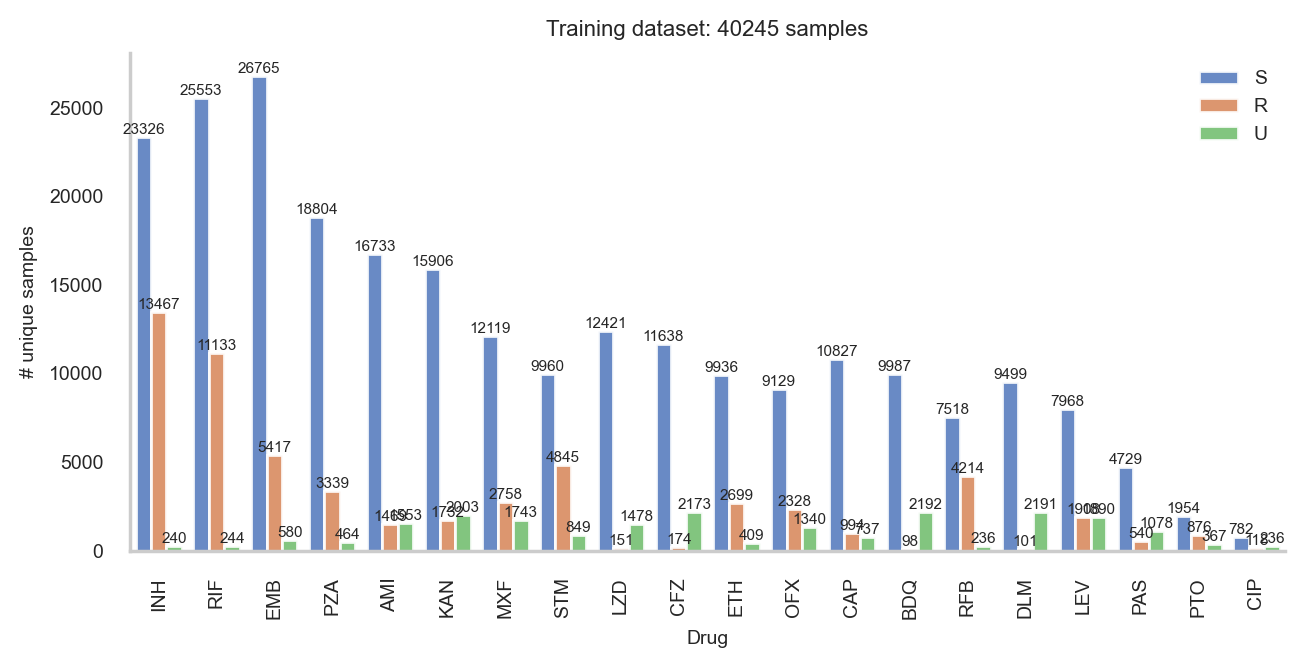

In [133]:
utils.plot_pheno_counts(crypticv1, 'Training dataset')

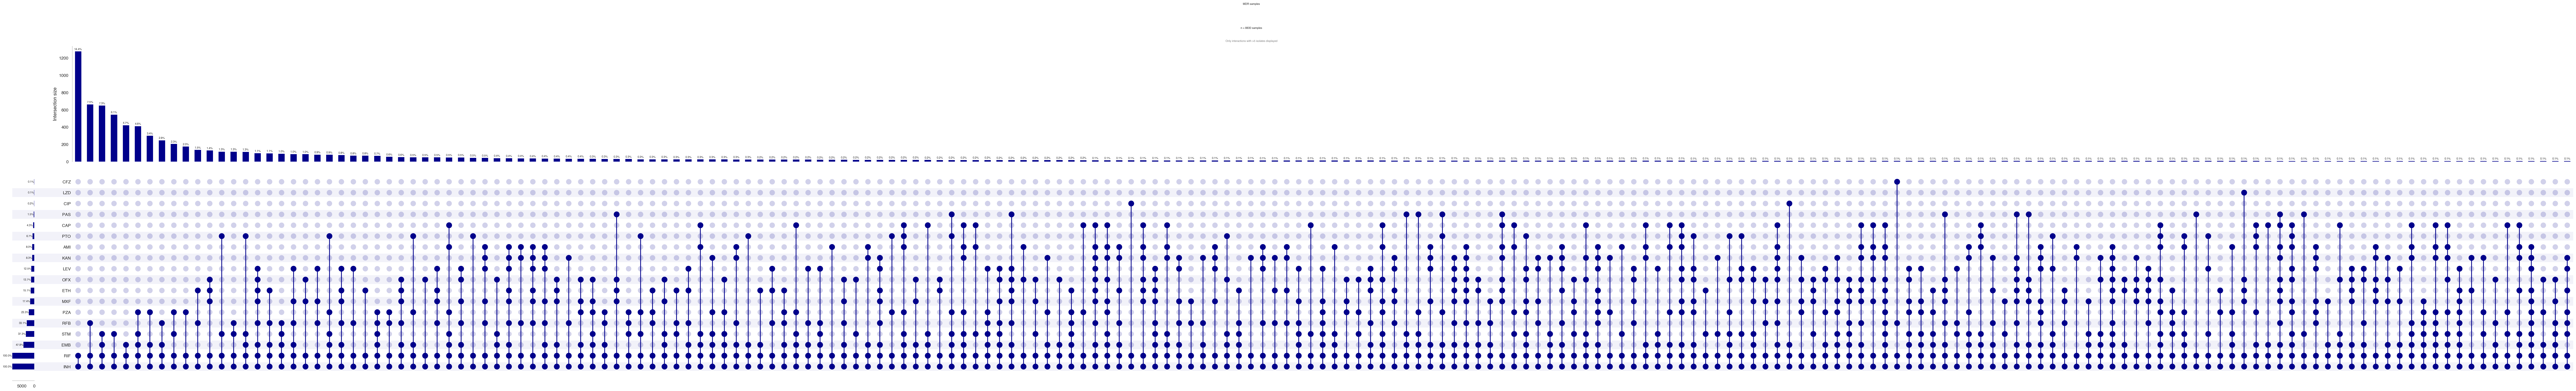

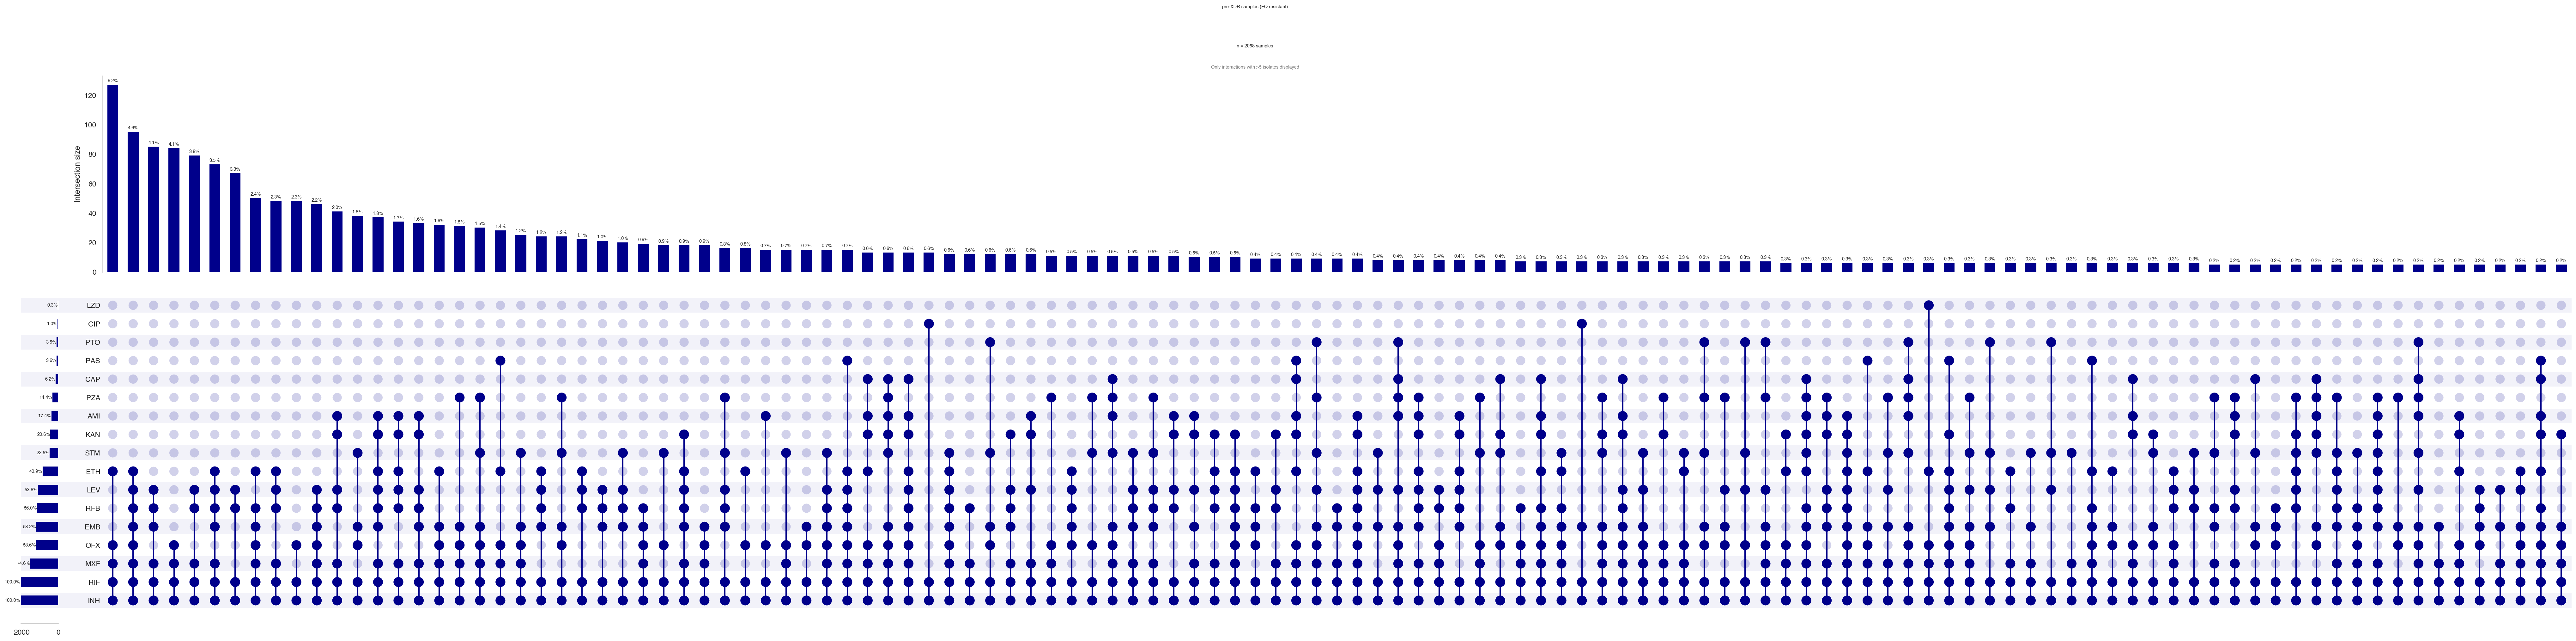

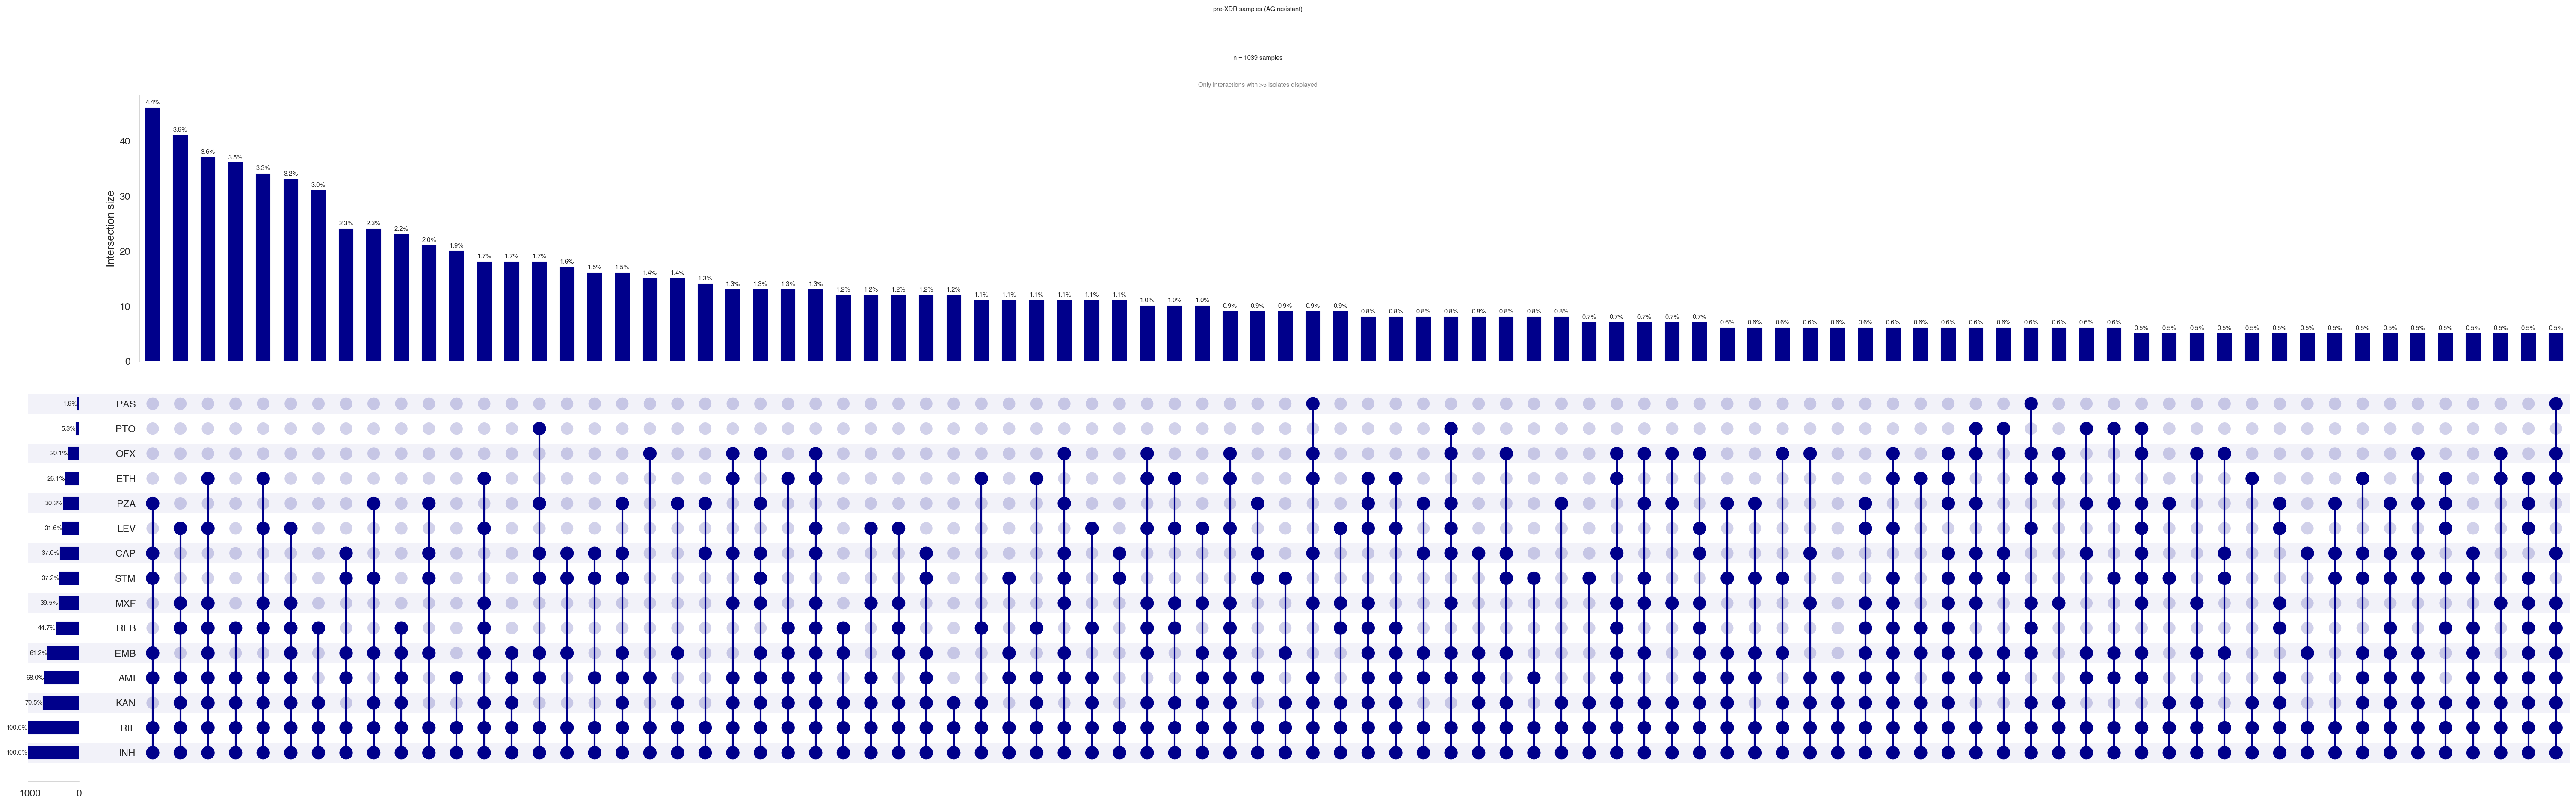

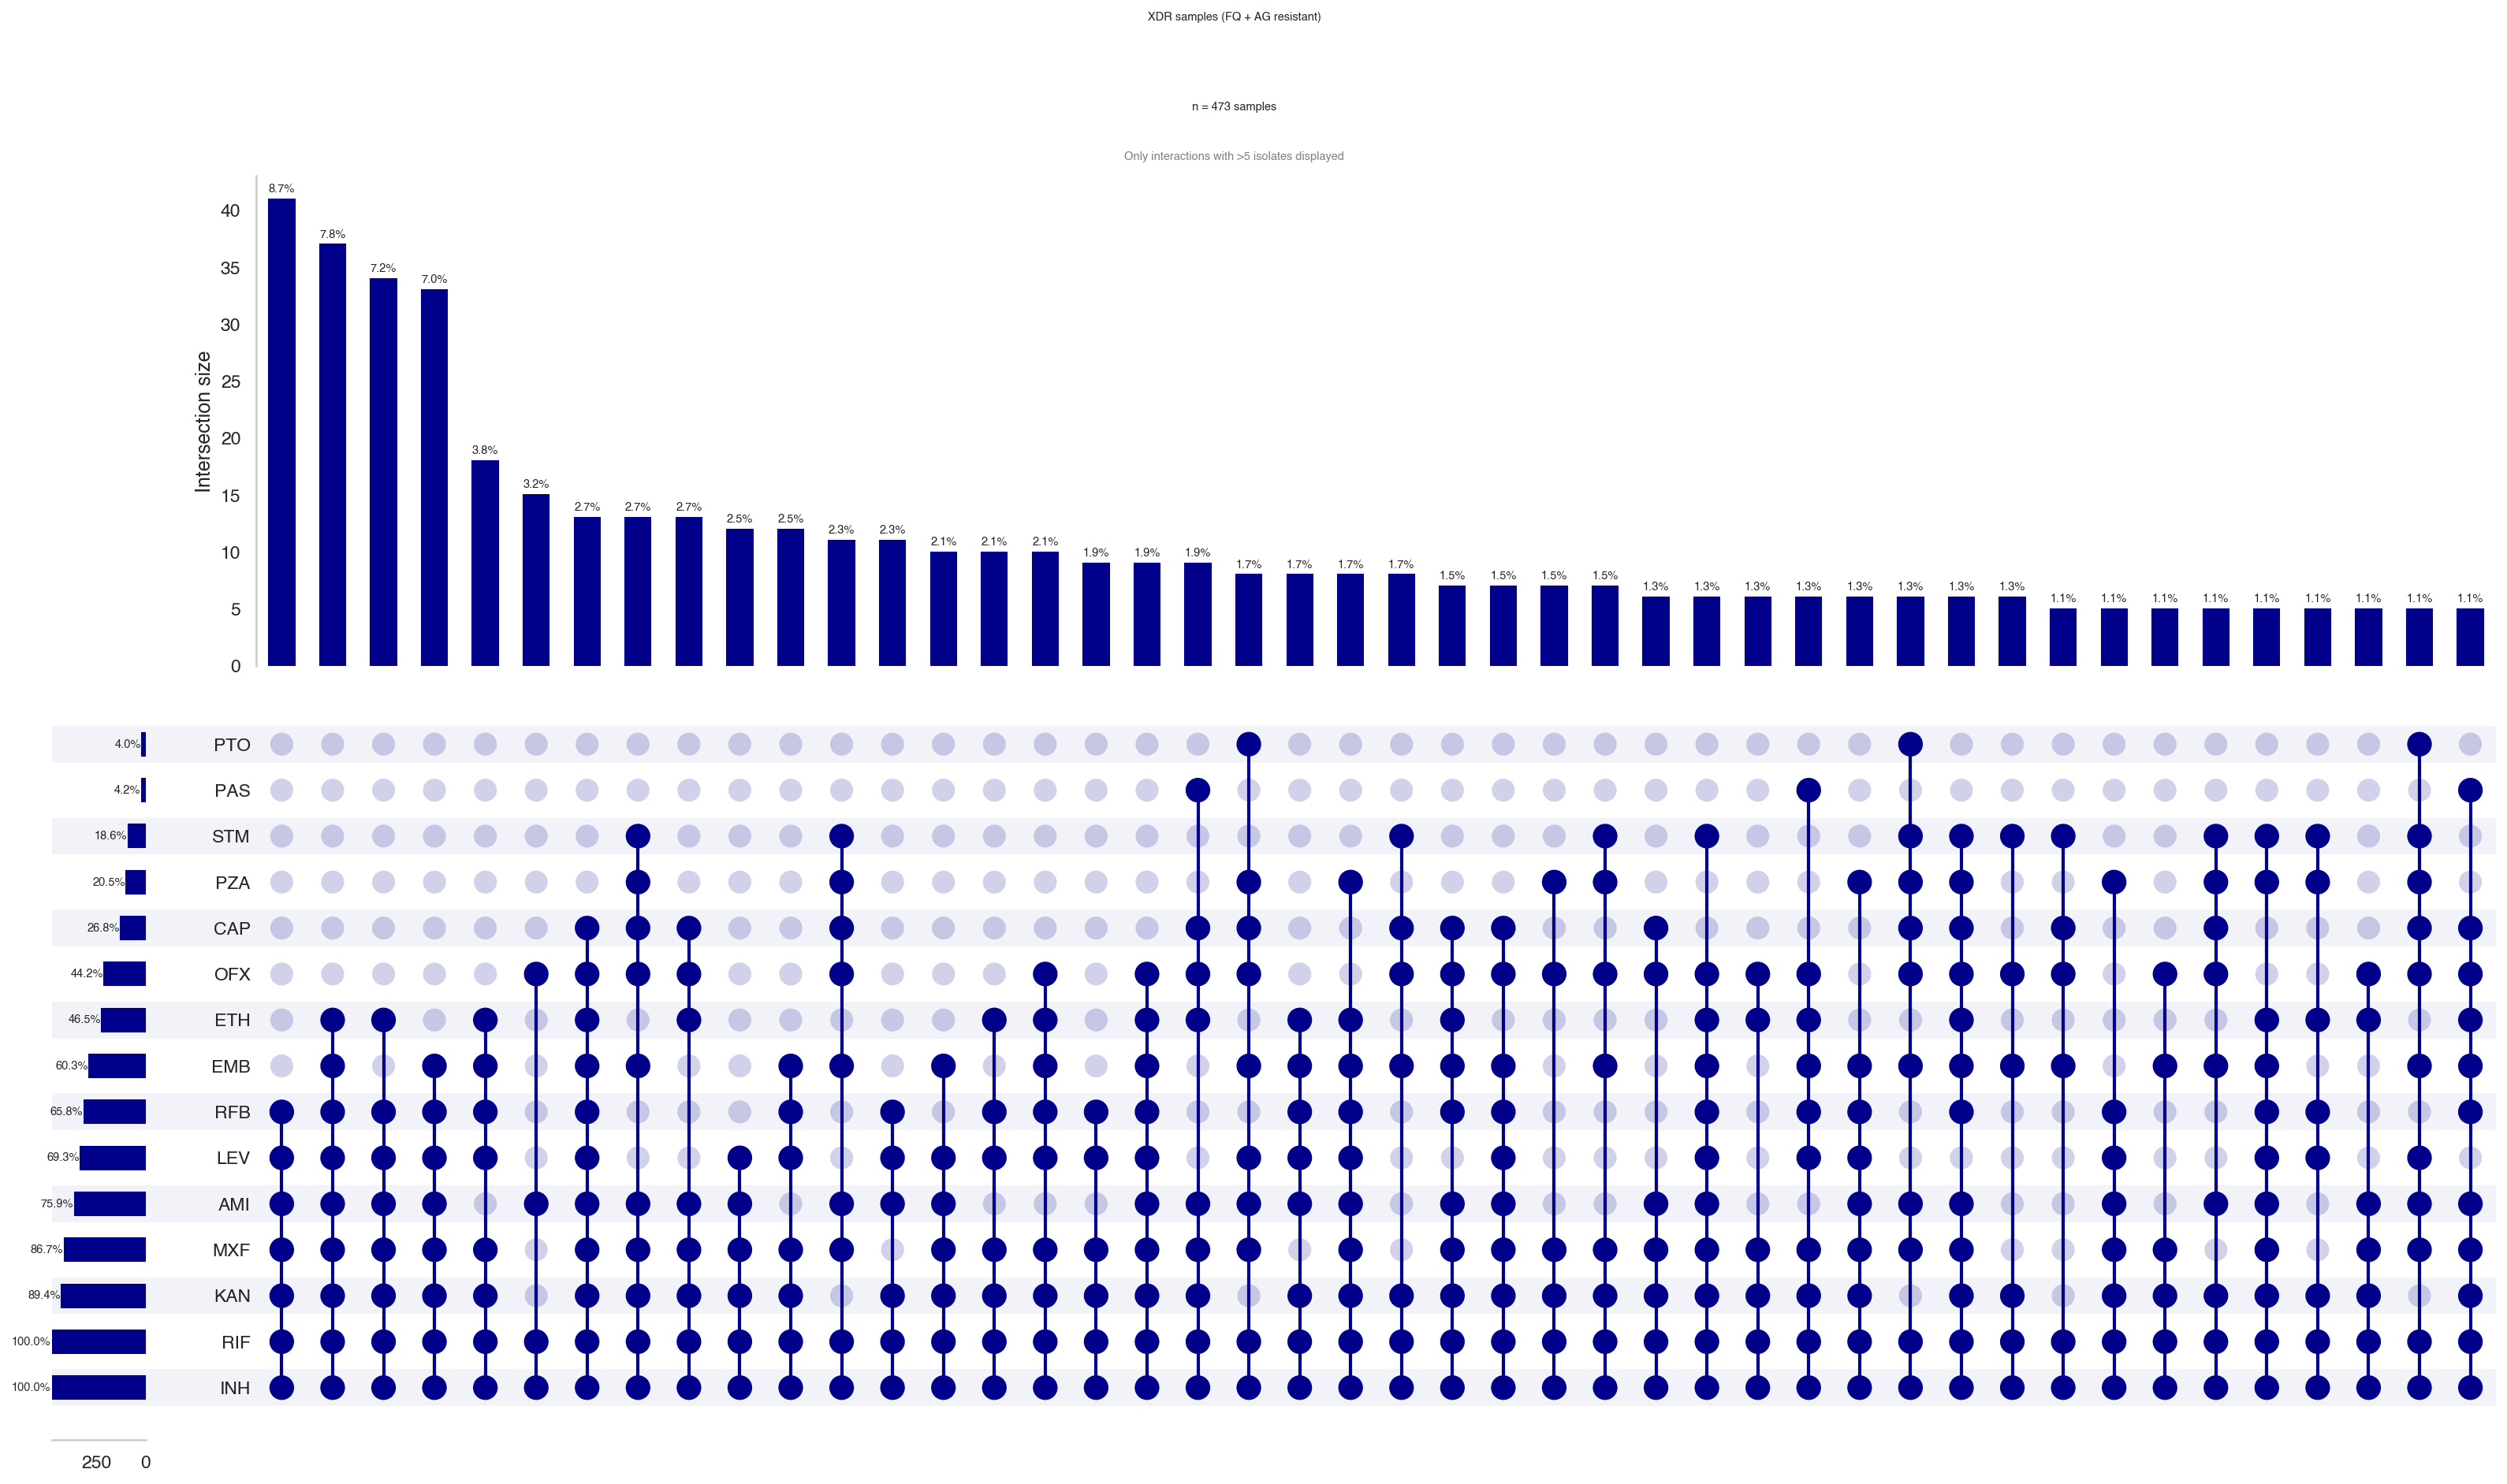

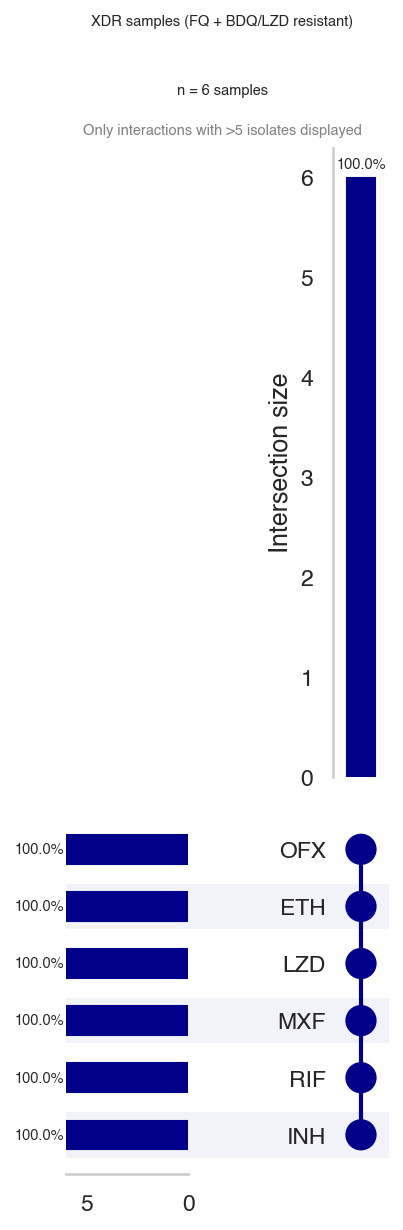

In [183]:
training_pivot = crypticv1.pivot(index="UNIQUEID", columns="DRUG", values=["PHENOTYPE"])

training_pivot.reset_index(inplace=True)

if isinstance(training_pivot.columns, pd.MultiIndex):
    training_pivot.columns = [col[1] if isinstance(col, tuple) else col for col in training_pivot.columns]
training_pivot_cleaned = training_pivot.fillna("")

for col in training_pivot_cleaned.columns[1:]:  # Skipping UNIQUEID
    training_pivot_cleaned[col] = training_pivot_cleaned[col].apply(lambda x: 1 if x == "R" else 0)

if "UNIQUEID" in training_pivot_cleaned.columns:
    training_pivot_cleaned.set_index("UNIQUEID", inplace=True)

training_pivot_cleaned.reset_index(inplace=True, drop=True)

total_counts = (
    crypticv1.groupby(['DRUG', 'PHENOTYPE'])['UNIQUEID']
    .nunique()
    .reset_index()
    .rename(columns={'UNIQUEID': 'count'})
).groupby('DRUG')['count'].sum().reset_index()

# Order DRUGs by total count descending
plot_order = total_counts.sort_values('count', ascending=False)['DRUG'].tolist()

# 1. MDR = RIF + INH
mdr_data, n_samples_mdr = utils.prepare_upset_data(
    training_pivot,
    "RIF == 'R' & INH == 'R'",
    plot_order
)
utils.create_upset_plot(mdr_data, "MDR samples", n_samples_mdr, f"./pdfs/MDR_training_upset_plot_20240117.pdf")

# 2. pre-XDR TB (FQ resistant)
preXDR_FQ_data, n_samples_preXDR_FQ = utils.prepare_upset_data(
    training_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OFX == 'R' | LEV == 'R' | CIP == 'R')",
    plot_order
)
utils.create_upset_plot(preXDR_FQ_data, "pre-XDR samples (FQ resistant)", n_samples_preXDR_FQ, f"./pdfs/preXDR_FQ_training_upset_plot_20240117.pdf")

# 3. pre-XDR TB (AG resistant)
preXDR_AG_data, n_samples_preXDR_AG = utils.prepare_upset_data(
    training_pivot,
    "RIF == 'R' & INH == 'R' & (KAN == 'R' | AMI == 'R' | CAP == 'R')",
    plot_order
)
utils.create_upset_plot(preXDR_AG_data, "pre-XDR samples (AG resistant)", n_samples_preXDR_AG, f"./pdfs/preXDR_AG_training_upset_plot_20240117.pdf")

# 4. XDR TB (FQ + AG resistant)
XDR_data, n_samples_XDR = utils.prepare_upset_data(
    training_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OFX == 'R' | LEV == 'R' | CIP == 'R') & (KAN == 'R' | AMI == 'R' | CAP == 'R')",
    plot_order
)
utils.create_upset_plot(XDR_data, "XDR samples (FQ + AG resistant)", n_samples_XDR, f"./pdfs/XDR_FQ_AG_training_upset_plot_20240117.pdf")

# 5. XDR TB (FQ + BDQ/LZD resistant)
XDR_BL_data, n_samples_XDR_BL = utils.prepare_upset_data(
    training_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OFX == 'R' | LEV == 'R' | CIP == 'R') & (BDQ == 'R' | LZD == 'R')",
    plot_order
)
utils.create_upset_plot(XDR_BL_data, "XDR samples (FQ + BDQ/LZD resistant)", n_samples_XDR_BL, f"./pdfs/XDR_FQ_BDQ_LZD_training_upset_plot_20240117.pdf")


#  Validation Data

In [162]:
v3_pheno = pd.read_pickle('data/cryptic-tables-v3.1.0/DST_MEASUREMENTS.pkl.gz').reset_index()
v3_pheno= v3_pheno.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)

v3_pheno = v3_pheno[~v3_pheno.DRUG.isin([ 'MPM','CYC','IMI','DCS','GEN','GFX','CLR'])]

v3_samples = pd.read_parquet('data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet').reset_index()
v3_samples = v3_samples[v3_samples.in_final_tables]

crypticv3 = v3_pheno[v3_pheno.UNIQUEID.isin(v3_samples.UNIQUEID.unique())]

set_v1 = set(crypticv1['UNIQUEID'])
set_v3 = set(crypticv3['UNIQUEID'])
set_val = set_v3 - set_v1

validation = crypticv3[crypticv3.UNIQUEID.isin(set_val)]


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_8033/2283810420.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  v3_pheno= v3_pheno.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)


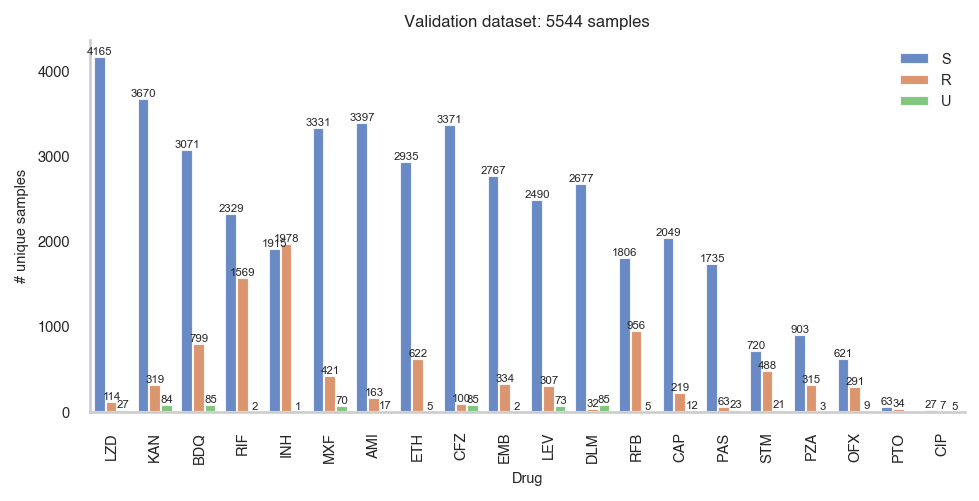

In [184]:
utils.plot_pheno_counts(validation, 'Validation dataset')

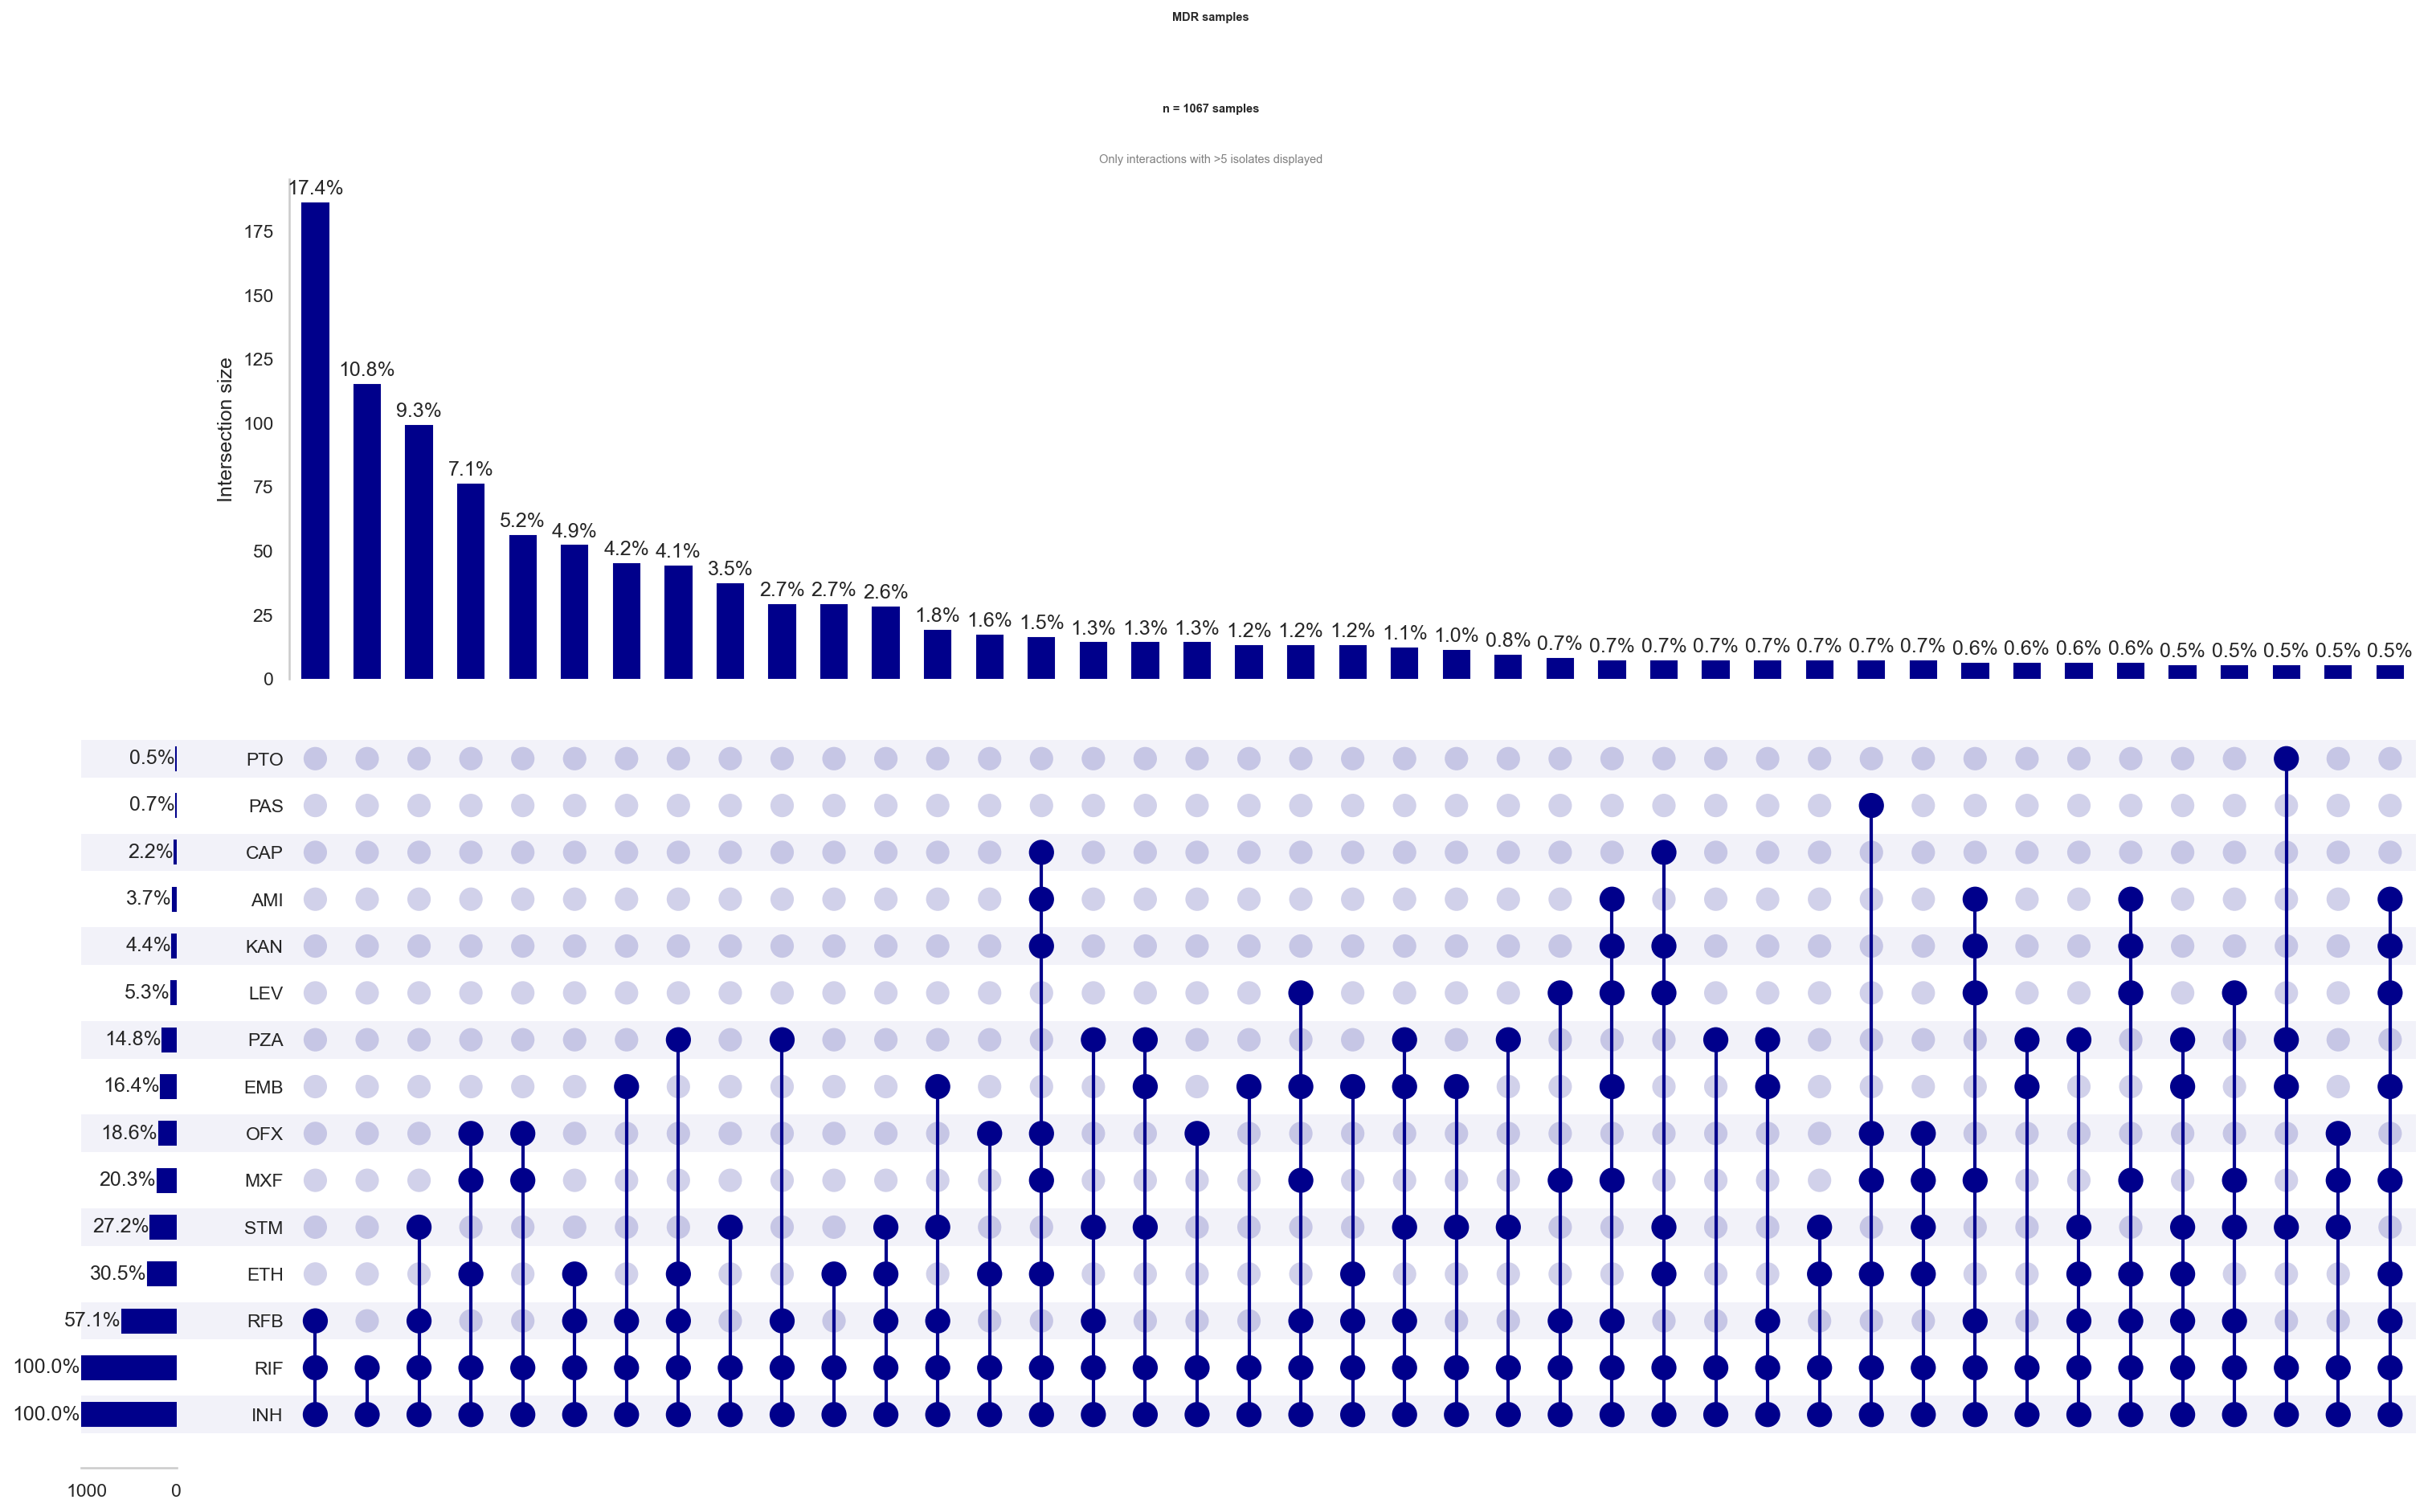

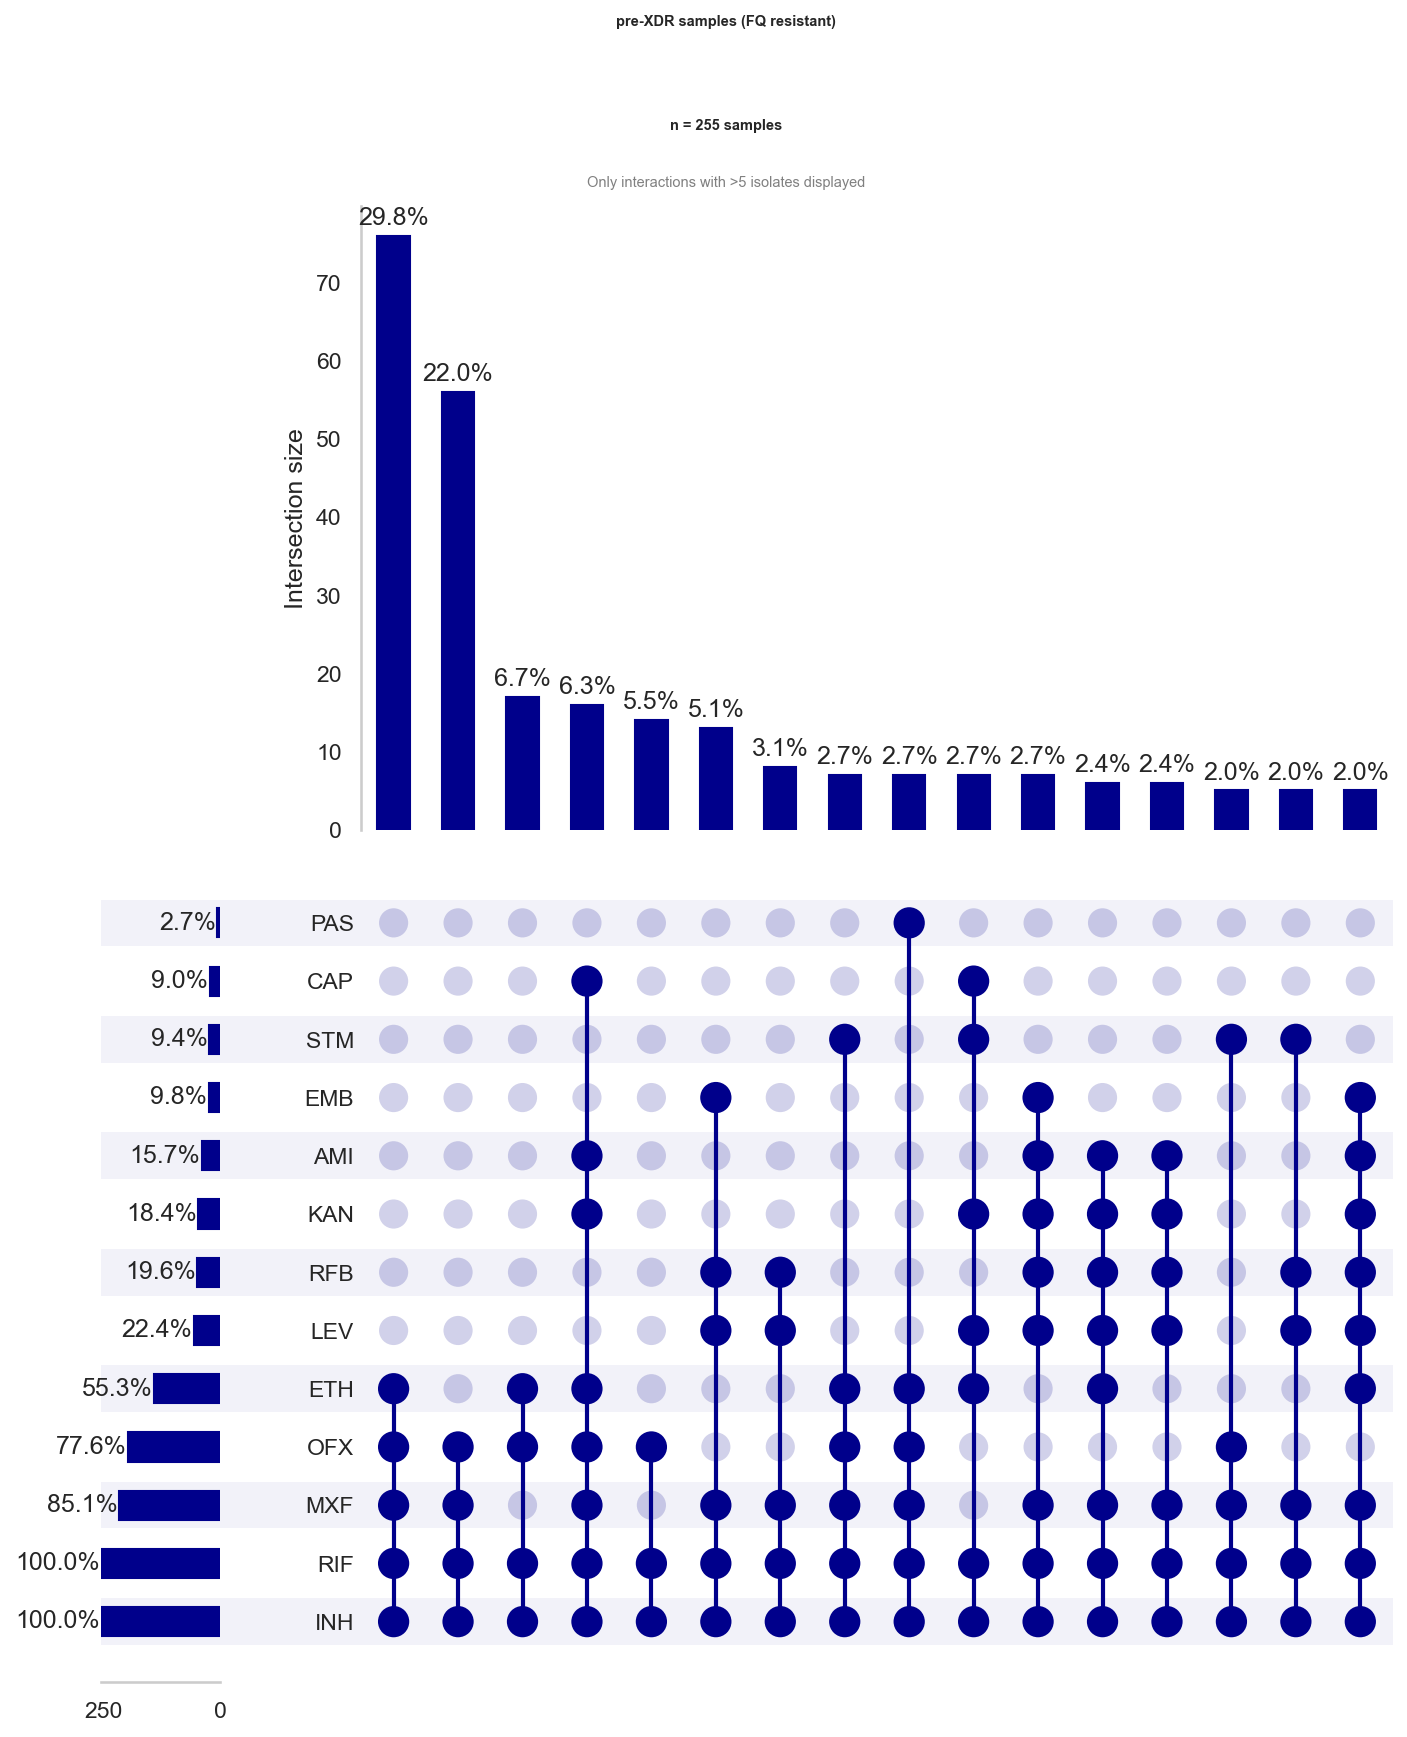

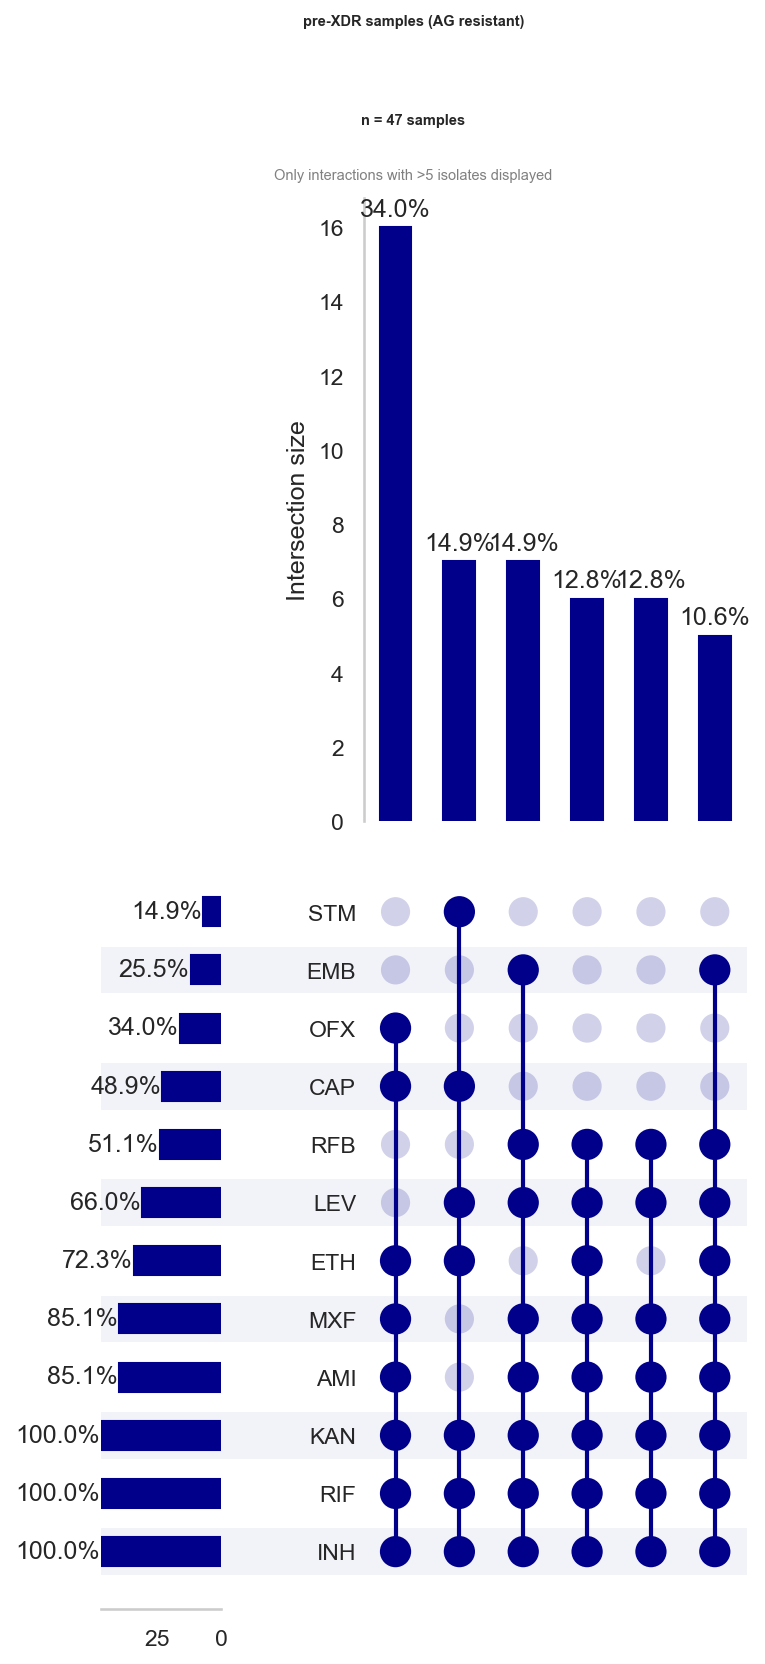

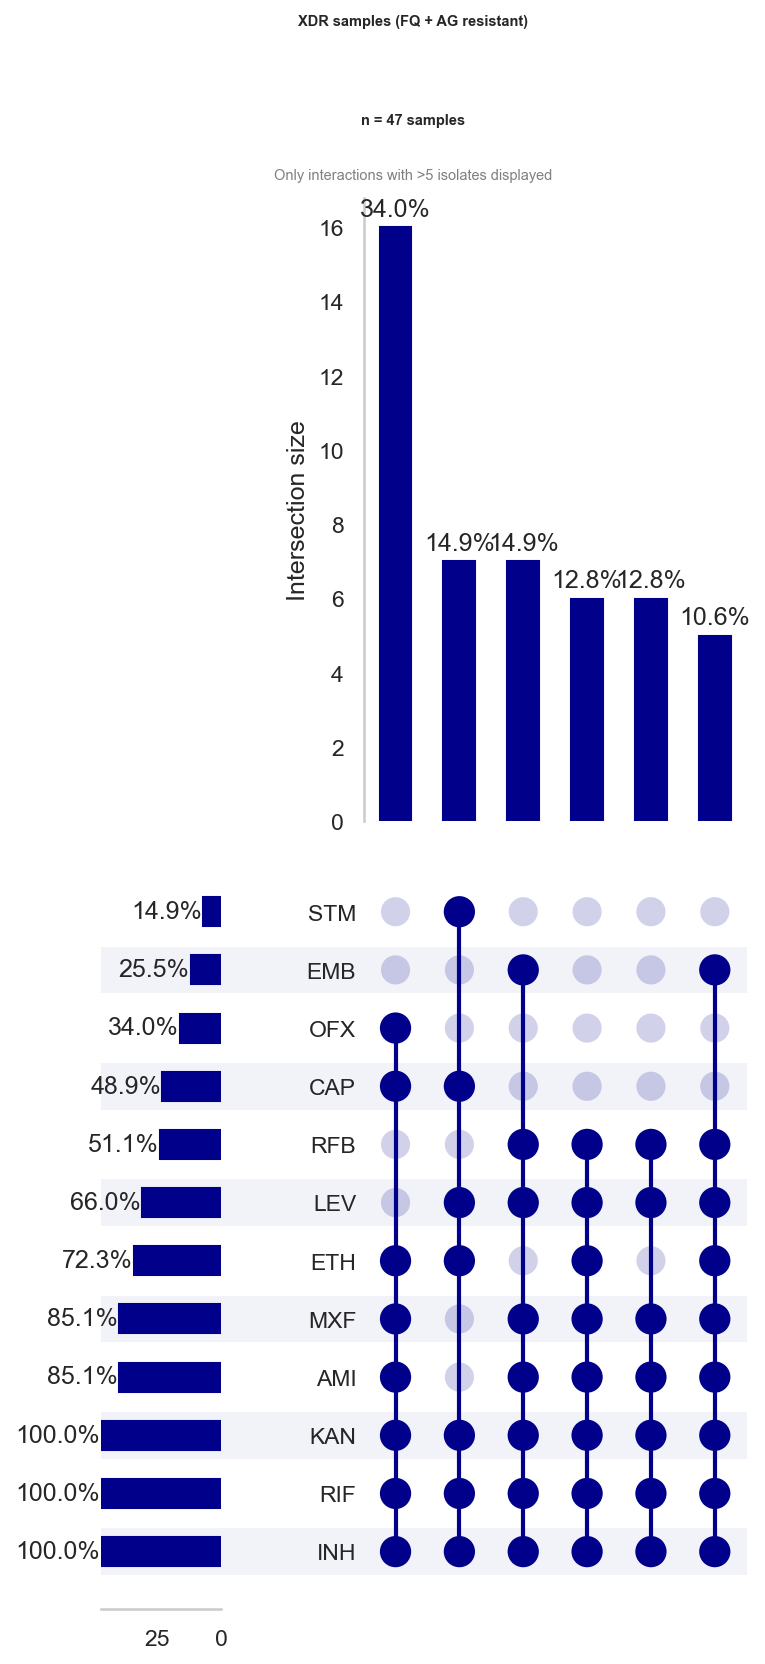

In [186]:
validation_pivot = validation.pivot(index="UNIQUEID", columns="DRUG", values=["PHENOTYPE"])

validation_pivot.reset_index(inplace=True)

if isinstance(validation_pivot.columns, pd.MultiIndex):
    validation_pivot.columns = [col[1] if isinstance(col, tuple) else col for col in validation_pivot.columns]
validation_pivot_cleaned = validation_pivot.fillna("")

for col in validation_pivot_cleaned.columns[1:]:  # Skipping UNIQUEID
    validation_pivot_cleaned[col] = validation_pivot_cleaned[col].apply(lambda x: 1 if x == "R" else 0)

if "UNIQUEID" in validation_pivot_cleaned.columns:
    validation_pivot_cleaned.set_index("UNIQUEID", inplace=True)

validation_pivot_cleaned.reset_index(inplace=True, drop=True)

total_counts = (
    crypticv1.groupby(['DRUG', 'PHENOTYPE'])['UNIQUEID']
    .nunique()
    .reset_index()
    .rename(columns={'UNIQUEID': 'count'})
).groupby('DRUG')['count'].sum().reset_index()

# Order DRUGs by total count descending
plot_order = total_counts.sort_values('count', ascending=False)['DRUG'].tolist()

# 1. MDR = RIF + INH
mdr_data, n_samples_mdr = utils.prepare_upset_data(
    validation_pivot,
    "RIF == 'R' & INH == 'R'",
    plot_order
)
utils.create_upset_plot(mdr_data, "MDR samples", n_samples_mdr, f"./pdfs/MDR_validation_upset_plot_20240117.pdf")

# 2. pre-XDR TB (FQ resistant)
preXDR_FQ_data, n_samples_preXDR_FQ = utils.prepare_upset_data(
    validation_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OFX == 'R' | LEV == 'R' | CIP == 'R')",
    plot_order
)
utils.create_upset_plot(preXDR_FQ_data, "pre-XDR samples (FQ resistant)", n_samples_preXDR_FQ, f"./pdfs/preXDR_FQ_validation_upset_plot_20240117.pdf")

# 3. pre-XDR TB (AG resistant)
preXDR_AG_data, n_samples_preXDR_AG = utils.prepare_upset_data(
    validation_pivot,
    "RIF == 'R' & INH == 'R' & (KAN == 'R' | AMI == 'R' | CAP == 'R')",
    plot_order
)
utils.create_upset_plot(preXDR_AG_data, "pre-XDR samples (AG resistant)", n_samples_preXDR_AG, f"./pdfs/preXDR_AG_validation_upset_plot_20240117.pdf")

# 4. XDR TB (FQ + AG resistant)
XDR_data, n_samples_XDR = utils.prepare_upset_data(
    validation_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OFX == 'R' | LEV == 'R' | CIP == 'R') & (KAN == 'R' | AMI == 'R' | CAP == 'R')",
    plot_order
)
utils.create_upset_plot(XDR_data, "XDR samples (FQ + AG resistant)", n_samples_XDR, f"./pdfs/XDR_FQ_AG_validation_upset_plot_20240117.pdf")

# 5. XDR TB (FQ + BDQ/LZD resistant)
XDR_BL_data, n_samples_XDR_BL = utils.prepare_upset_data(
    validation_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OFX == 'R' | LEV == 'R' | CIP == 'R') & (BDQ == 'R' | LZD == 'R')",
    plot_order
)
if n_samples_XDR_BL>0:
    utils.create_upset_plot(XDR_BL_data, "XDR samples (FQ + BDQ/LZD resistant)", n_samples_XDR_BL, f"./pdfs/XDR_FQ_BDQ_LZD_validation_upset_plot_20240117.pdf")
